## Neural Network from scratch

In [174]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
import random
%matplotlib inline

In [19]:
def f(x):
    return 3*x**2 - 4*x + 5 # Equation for a parabola

In [20]:
f(3.0)

20.0

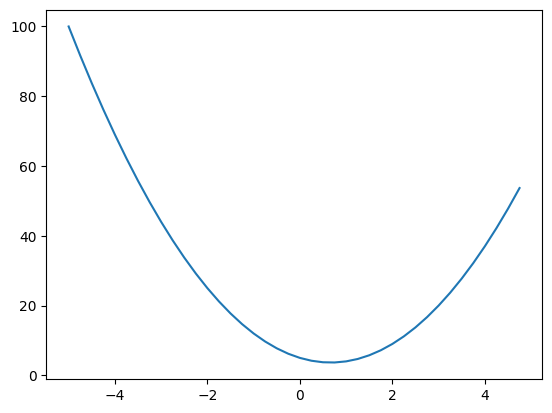

In [21]:
# Feed a range of numbers to plot the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

# Now plot the result
plt.plot(xs, ys)

In [22]:
# Now we will find the derivative of the function to see how the values change if we slightly increase the value of x
h = 0.000001
x = 2/3 # At this value the slope will become 0
(f(x+h) - f(x))/h

2.999378523327323e-06

In [23]:
# Lets get more complex
# We will use 3 scalars a,b and c and their output will be d
a = 2.0
b = -3.0
c = 10.0
d = a*b+c

In [24]:
# Now we will look through derivatives of d wrt a,b and c
# To evaluate this derivative we will again take a small value of h
h = 0.001
# Then fix the inputs at some values
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# If we look at the derivative of d wrt a
a += h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.997
slope -3.0000000000001137


In [239]:
# Since the derivative expressions for a Neural Network are complex, we will use a class to represent it.
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0  # This variable maintains the derivative of output(L) wrt. data (this value)
        # This value is initially 0, which means there is no effect. At initialization we are assuming that this value
        # does not affect the output. Changing this variable is not changing the output.
        self._backward = lambda: None # create an empty function that can store the backward propagation function for an operation
    
    def __repr__(self) -> str:
        # Use this function to display the object as you like
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            # since it is addition we propagate the gradient as is to both the nodes
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            # In multiplication we use chain rule to multiply the 
            # gradient of 'out' with the value of the opposite node
            self.grad += other.data * out.grad # += is for multivariable gradient, so one doesn't overwrite the other
            other.grad += self.data * out.grad
        out._backward = _backward 
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            # The gradient for x**n is n*x**n-1
            # using it with chain rule
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        # a / b = a * (1/b) = a * (b**-1 )
        return self * other**-1
    
    def tanh(self):
        # To calculate tanh of a node
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), "tanh")
        def _backward():
            # for tanh the backward prop will be do/dn = 1 - tanh(n)**2
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        def _backward():
            self.grad += out.data * out.grad # The gradient of y = e^x is y and out.grad is chain rule
        out._backward = _backward
        return out
    
    def backward(self):
        """
        This function implements topological sort which 
        sorts the nodes of a graph from left to right.
        Then it iterates through the sorted nodes and calls _backward function on each node
        """
        # Topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0 # gradient of the output node
        for node in reversed(topo):
            node._backward()


In [170]:
def trace(root):
    # builds the set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'}) # LR = Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f } " % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is the result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [134]:
# Example of Value object
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label="e"
d = e + c ; d.label="d" # (a.__mul__(b)).__add__(c)
f = Value(-2.0, label="f")
L = d * f; L.label="L"
L

Value(data=-8.0)

In [152]:
# Doing operations with numbers and Value objects
a = Value(2.0)
# a * 2 # Now we need to convert to into a value object for this operation

# Now if you try to do 2 * a or 2 + a you will get an error - for this we implement __rmul__ and __radd__ .
# In this python checks if another way around is possible and does that.
print(2 * a)


Value(data=4.0)


In [136]:
# draw_dot(L)

In [54]:
L.grad = 1.0

Now we calculate the derivatives of d and f wrt L (output) - find the proof later  
L = d * f   
dL/dd = f  
dL/df =d

In [56]:
# using the above we have the gradients for d and f 
f.grad = 4.0
d.grad = -2.0

Now we will derive dL/dc - derivative of L wrt the node c  
dL/dc = ?  

- First we calculate the local derivatives - dd/dc and dd/de
dd/dc = 1.0  
d = c + e  
(f(x + h) - f(x)) / h  
(f(d + h) - f(d)) / h  
((c + e + h) - (c+ e)) / h  
(c + e + h - c - e) / h  
h / h = 1.0  

- Similarly dd/de = 1.0 as well
- Since now we have the intermediate derivatives we can calculate the derivative of L wrt c - dL/dc using chain rule in calculus.
- According to the chain rule dz/dx = dz/dy * dy/dx - by using an intermediate value y we can calculate dz/dx.
- Similarly dL/dc = dL/dd * dd/dc
- dL/dc = -2.0 * 1.0 = -2.0
- dL/de = -2.0 * 1.0 = -2.0 

In [58]:
c.grad = -2.0
e.grad = -2.0

Finally we come to the last node dL/da and dL/db  
- To get this we will again apply the chain rule.
- We know from previous derivatives that dL/de = -2.0
- de/da = b = -3.0
- The chain rule will be dL/da = dL/de * de/da = -2.0 * -3.0 = 6.0
- dL/db = dL/de * de/db = -2.0 * 2.0 = -4.0

In [60]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

### Building a Neuron

In [160]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2 (like strength of synaptic connections in brain)
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neural network
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# -- Break tanh into its component operations - tanh = e^2x -1 / e^2x + 1
o = n.tanh(); o.label = "o"

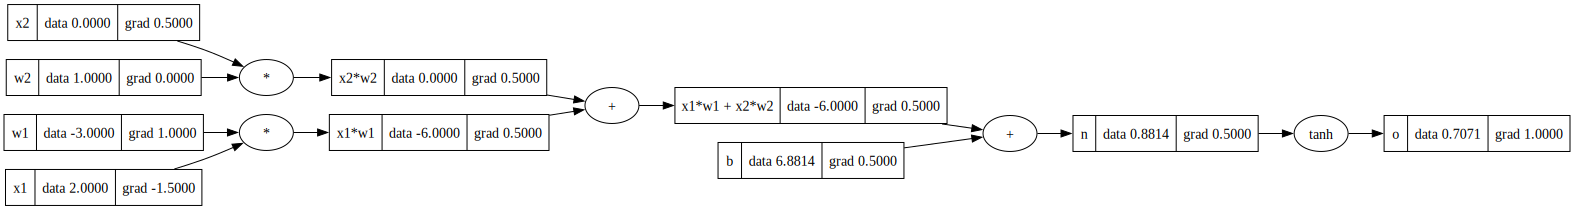

In [163]:
draw_dot(o)

In [162]:
# Backprop using the backward() function and topological sort
o.backward()

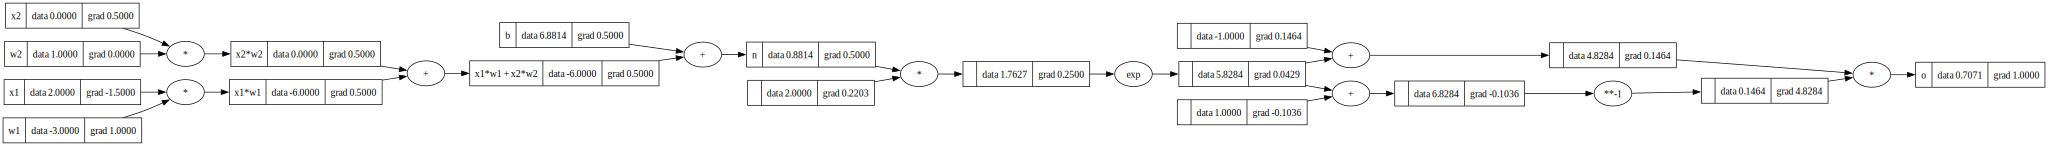

In [240]:
# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2 (like strength of synaptic connections in brain)
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neural network
b = Value(6.8813735870195432, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
# -- Break tanh into its component operations - tanh = e^2x -1 / e^2x + 1
e = (2*n).exp()
o = (e - 1) / (e + 1) # e - 1 can be written as e + (-1)
# --------
o.label = "o"
o.backward()
draw_dot(o)

### Using Pytorch Tensors
- Now we will use pytorch tensors for the above example.
- In pytorch everything is based on tensors.
- Tensors are n-dimensional arrays of scalars.

In [171]:
import torch

In [172]:
# We use double because its the default type in python
x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True # by default it is False for leaf nodes for efficiency
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("----")
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


### Building a Neural Network (Multilayer Perceptron)

In [206]:
class Neuron:
    def __init__(self, nin): # nin - The inputs for the neural net (x1, x2, ....) 
        # define random weights
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): # When calling the object
        # w * x + b
        # for calculating activation
        act = sum((xi * wi   for wi, xi in zip(self.w, x)), self.b) 
        out = act.tanh() # pass the output through activation function which here is tanh
        return out
    
    def parameters(self):
        # Returns the parameters of a neuron
        return self.w + [self.b]


class Layer:
    # A layer contains a number of neurons
    def __init__(self, nin, nout):
        """
        nin - input for each neuron
        nout - number of neurons in a layer
        For the given number of neurons we will create a layer
        """
        self.neurons = [Neuron(nin) for _ in range(nout)] # list of neurons
        
    def __call__(self, x):
        """
        x - List of inputs to a neuron
        will return a list of neurons (layer)
        """
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters()]
            
        
class MLP:
    def __init__(self, nin, nouts):
        """
        nin - Number of layers
        nouts - a list of number of neurons in each layer
        Ex:
        MLP(3, [4, 4, 1]) - This initializes a Multilayer neural network
        which contains 3 layers, 2 layers of 4 neurons  and 1 layer of 1 output neuron
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [231]:
x = [2.0, 3.0, -1.0] # 3 inputs
# n = Neuron(2) # Initialize the Neuron with the number of inputs
# n(x) # Then call it with inputs
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.7924310171666363)

In [209]:
len(n.parameters())

41

In [232]:
# Example
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
] # inputs
ys = [1.0, -1.0, -1.0, 1.0] # desired targets (labels)

In [237]:
# Put it all together
for k in range(20):

    # forward pass - calculate loss
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # using  mean squared error

    # Before doing backward pass, we need to reset the gradients of the parameters to zero so 
    # they can be calculated again wrt to the loss
    for p in n.parameters():
        p.grad = 0.0
    # backward pass - or backpropagation
    loss.backward()

    # update the parameters by a small step to minimize the loss
    for p in n.parameters():
        p.data += -0.1 * p.grad # The -ve sign is because we want to minimize the loss so we point the value in the opposite direction

    print(k, loss.data)

0 0.01837033375815207
1 0.017889373432555748
2 0.017432316154912735
3 0.016997441671412664
4 0.01658318995194673
5 0.016188143033237977
6 0.01581100926952078
7 0.015450609627150806
8 0.015105865720865119
9 0.014775789339364142
10 0.014459473248753733
11 0.014156083095961114
12 0.013864850261943897
13 0.013585065537459086
14 0.013316073513241036
15 0.013057267592364363
16 0.012808085545905342
17 0.012568005544226164
18 0.01233654260565634
19 0.012113245412339588


In [238]:
ypred

[Value(data=0.942799021840657),
 Value(data=-0.9390547191528597),
 Value(data=-0.94251206572938),
 Value(data=0.95731389376256)]

In [211]:
# Calculate the loss - difference between the desired output and the predicted output
# This is done using Mean Squared error
ypred = [n(x) for x in xs]
loss = sum((yout + -(ygt))**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.002776709437022)

In [220]:
loss.backward()

In [217]:
n.layers[0].neurons[0].w[0].grad

0.15504942042911415

In [216]:
n.layers[0].neurons[0].w[0].data

0.3757774777985637

### Gradient Descent
- In gradient descent we can think of the gradient as a vector pointing in a direction of increased loss.
- So we modify the data by a small step size in the direction of the gradient.

In [221]:
# Iterate over all the parameters and modify them by a small step size
for p in n.parameters():
    p.data += -0.01 * p.grad # The -ve sign is because we want to minimize the loss so we point the value in the opposite direction

### Back propagation using the _backward function

In [124]:
o.grad = 1.0

In [125]:
o._backward() # backprop for n

In [126]:
n._backward() # backprop for b and x1w1x2w2

In [127]:
b._backward() # as there is no backward, nothing will happen

In [128]:
x1w1x2w2._backward()

In [132]:
x1w1._backward()
x2w2._backward()


### Manual Backprop calculation for a Neuron

In [97]:
# derivative of o wrt o do/do = 1
o.grad = 1.0

In [83]:
# derivative of o wrt n - do/dn
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 - see derivative of tanh(x) from wikipedia
# do/dn = 1 - o**2 = 1 - 0.7071**2 = 0.5
# 1 - o.data**2
n.grad = 0.5

In [84]:
# since the local gradients for "+" is 1 - the gradient for the leaf nodes will be the same
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [85]:
# following the same rule
x1w1.grad = 0.5
x2w2.grad = 0.5

In [87]:
# do/dx2 = do/dx2w2 * dx2w2/dx2
x2.grad = x2w2.grad * w2.data

# do/dw2 = do/dx2w2 * dx2w2/dw2
w2.grad = x2w2.grad * x2.data

In [89]:
# do/dx1 = do/dx1w1 * dx1w1/dx1
x1.grad = x1w1.grad * w1.data

# do/dw2 = do/dx1w1 * dx1w1/dw1
w1.grad = x1w1.grad * x1.data